## Amplitude Analysis

In [3]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm
import pickle

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


/usr/local/lib/python3.8/dist-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
include_wls = False

In [5]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        if n%2 != 1:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n-1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n/2)))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
        else:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n+1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [6]:
def min_max_in_window(array, window, return_index = False):
    x_min, x_max = np.zeros(array.shape[0]), np.zeros(array.shape[0])
    a_min, a_max = np.zeros(array.shape[0]), np.zeros(array.shape[0])
    
    ind = np.arange(array.shape[0])
    for i in np.arange(array.shape[1]-window+1):
        interval = array[:,i:i+window]
        t_min = np.min(array, axis=1) #temporary min
        t_max = np.max(array, axis=1) #temporary max
        t_argmin = np.argmin(interval, axis=1)+i
        t_argmax = np.argmax(interval, axis=1)+i
        mask = t_max-t_min > x_max-x_min
        x_min[ind[mask]] = t_min[ind[mask]]
        x_max[ind[mask]] = t_max[ind[mask]]
        a_min[ind[mask]] = t_argmin[ind[mask]]
        a_max[ind[mask]] = t_argmax[ind[mask]]
    if return_index:
        return x_max-x_min, a_min, a_max
    else:
        return x_max-x_min

In [7]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency=80*u.Hz): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [8]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, distance, frequency=80*u.Hz):
    binning = get_binning(sim, dt, frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)
    
    return sa_gen2, sa_ic86

In [9]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun,
             'direction': 1}
         }
sim = Simulation(model=model,
                 distance=10 * u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

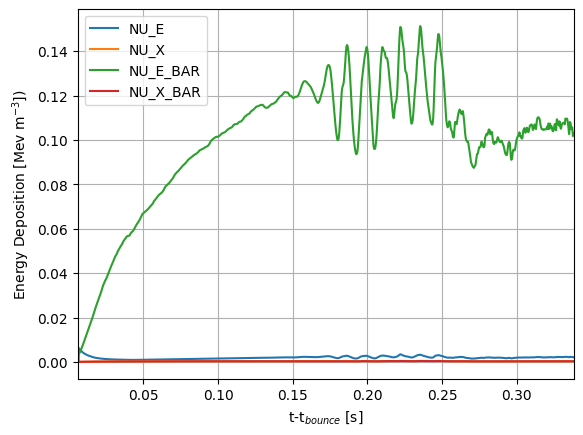

In [10]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0.006, 0.338))
ax.grid()

In [11]:
dt = 1 * u.ms
sasi_wind = [140, 300] * u.ms
ana_wind = [160, 275] * u.ms

In [12]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

In [13]:
def signal_processing(sim, dt, distance, trials, minmax_window=None, dist = skewnorm, sig_method='pdf_median',
                      return_raw=False,
                      return_corrected=False,
                      return_deviation=False, 
                      return_percentage=False, 
                      return_max_percentage=False,
                      return_significance=False):
    
    if minmax_window == None:
        minmax_window = get_binning(sim, dt)
    
    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    #t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
    t = t.to(u.ms)
    
    # dead time corrected, distance corrected signal
    sc_i3 = s_i3 * 1/sim.eps_i3 * (distance/10*u.kpc)**2
    sc_dc = s_dc * 1/sim.eps_dc * (distance/10*u.kpc)**2
    sc_md = s_md * 1/sim.eps_md * (distance/10*u.kpc)**2

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])

    ### SIGNAL TRIALS ###
    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md

    # combined signal S: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2

    # background subtraction Sb: signal + background - average background
    Sb_ic86 = S_ic86 - ba_ic86
    Sb_gen2 = S_gen2 - ba_gen2
    
    # deviation Sd: signal + background - average background - average signal
    Sd_ic86 = Sb_ic86 - sa_ic86
    Sd_gen2 = Sb_gen2 - sa_gen2

    # percentage deviation Sp: (signal + background - average background)/average signal
    Sp_ic86 = (Sb_ic86/sa_ic86)-1
    Sp_gen2 = (Sb_gen2/sa_gen2)-1
    
    Sm_ic86 = min_max_in_window(Sp_ic86[:,np.logical_and(t>=ana_wind[0], t<=ana_wind[1])], window=minmax_window)
    Sm_gen2 = min_max_in_window(Sp_gen2[:,np.logical_and(t>=ana_wind[0], t<=ana_wind[1])], window=minmax_window)

    ### BACKGROUND TRIALS ###
    # combined signal S: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2

    # background subtraction Sb: average signal + background - average background
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # deviation Sd: average signal + background - average background - average signal = background - average background
    Bd_ic86 = b_ic86 - ba_ic86
    Bd_gen2 = b_gen2 - ba_gen2

    # percentage deviation Sp: (average signal + background - average background)/average signal
    Bp_ic86 = (Bb_ic86/sa_ic86)-1
    Bp_gen2 = (Bb_gen2/sa_gen2)-1
    
    Bm_ic86 = min_max_in_window(Bp_ic86[:,np.logical_and(t>=ana_wind[0], t<=ana_wind[1])], window=minmax_window)
    Bm_gen2 = min_max_in_window(Bp_gen2[:,np.logical_and(t>=ana_wind[0], t<=ana_wind[1])], window=minmax_window)
    
    # background fit parameters
    Bfp_ic86 = dist.fit(Bm_ic86)
    Bfp_gen2 = dist.fit(Bm_gen2)

    # fitted background distribution
    Bf_ic86 = dist(*Bfp_ic86)
    Bf_gen2 = dist(*Bfp_gen2)
    
    ### SIGNIFICANCE ###
    if sig_method == 'weighted_difference':
    # Defined as difference between the mean of the signal and background distribution devided by the square root
    # of the sum of the variance of the two distributions
        Z_ic86 = np.abs(Sm_ic86.mean()-Bm_ic86.mean())/np.sqrt(Sm_ic86.std()**2+Bm_ic86.std()**2)
        Z_gen2 = np.abs(Sm_gen2.mean()-Bm_gen2.mean())/np.sqrt(Sm_gen2.std()**2+Bm_gen2.std()**2)
    elif sig_method == 'pdf_median':
    # take the median of the signal trials and compute the corresponding p-value/significance from the bkg distribution
                
        # p-value of signal given a background distribution
        p_ic86 = Bf_ic86.sf(np.median(Sm_ic86))
        p_gen2 = Bf_gen2.sf(np.median(Sm_gen2))

        # two-sided Z score corresponding to the respective p-value, survival probability = 1 - cdf
        Z_ic86 = norm.isf(p_ic86/2)
        Z_gen2 = norm.isf(p_gen2/2)

    if return_raw:
        return t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86
    
    if return_corrected:
        return t, sc_i3, sc_dc, sc_md
    
    if return_deviation:
        return t, Sd_gen2, Sd_ic86, Bd_gen2, Bd_ic86
    
    if return_percentage:
        return t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_max_percentage:
        return t, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86
    
    if return_significance:
        return Z_gen2, Z_ic86

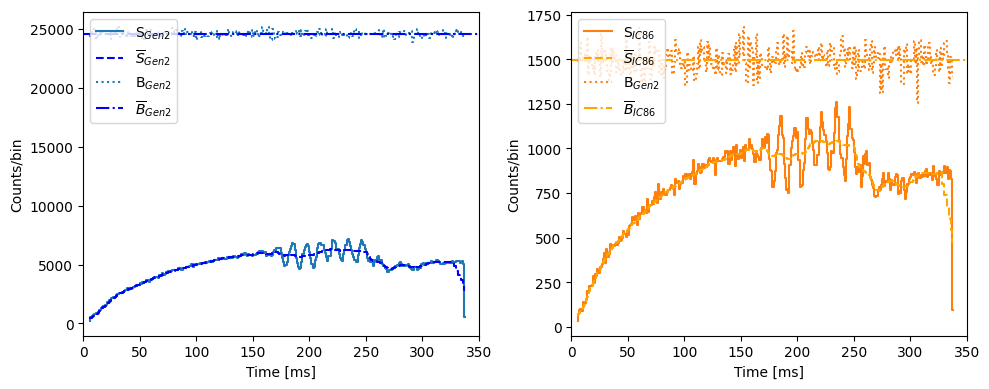

In [56]:
t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10000, return_raw=True)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,s_gen2[0], color = 'C0', ls = '-', label=r'S$_{Gen2}$')
ax[0].step(t,sa_gen2, color = 'blue', ls = '--', label=r'$\overline{S}_{Gen2}$')
ax[0].step(t,b_gen2[0], color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].axhline(ba_gen2, color = 'blue', ls = '-.', label=r'$\overline{B}_{Gen2}$')
ax[1].step(t,s_ic86[0], color = 'C1', ls = '-', label=r'S$_{IC86}$')
ax[1].step(t,sa_ic86, color = 'orange', ls = '--', label=r'$\overline{S}_{IC86}$')
ax[1].step(t,b_ic86[0], color = 'C1', ls = ':', label=r'B$_{Gen2}$')
ax[1].axhline(ba_ic86, color = 'orange', ls = '-.', label=r'$\overline{B}_{IC86}$')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlim(0,350)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Counts/bin')
ax[1].set_xlim(0,350)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

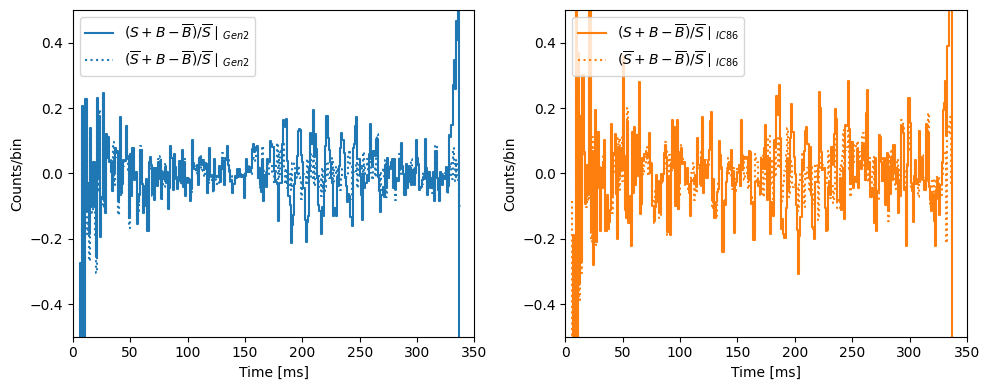

In [57]:
t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10, return_percentage=True)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,Sp_gen2[0], color = 'C0', ls = '-', label=r'$(S+B-\overline{B})/\overline{S}\mid_{Gen2}$')
ax[0].step(t,Bp_gen2[0], color = 'C0', ls = ':', label=r'$(\overline{S}+B-\overline{B})/\overline{S}\mid_{Gen2}$')
ax[1].step(t,Sp_ic86[0], color = 'C1', ls = '-', label=r'$(S+B-\overline{B})/\overline{S}\mid_{IC86}$')
ax[1].step(t,Bp_ic86[0], color = 'C1', ls = ':', label=r'$(\overline{S}+B-\overline{B})/\overline{S}\mid_{IC86}$')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlim(0,350)
ax[0].set_ylim(-0.5,0.5)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Counts/bin')
ax[1].set_xlim(0,350)
ax[1].set_ylim(-0.5,0.5)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

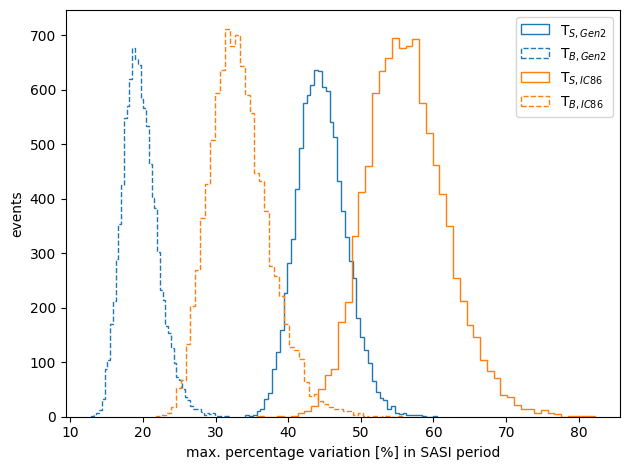

In [58]:
t, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10000, minmax_window=10, return_max_percentage=True)
plt.hist(Sm_gen2*100, bins = 50, histtype='step', color = 'C0', ls = '-', label=r'T$_{S,Gen2}$')
plt.hist(Bm_gen2*100, bins = 50, histtype='step', color = 'C0', ls = '--', label=r'T$_{B,Gen2}$')
plt.hist(Sm_ic86*100, bins = 50, histtype='step', color = 'C1', ls = '-', label=r'T$_{S,IC86}$')
plt.hist(Bm_ic86*100, bins = 50, histtype='step', color = 'C1', ls = '--', label=r'T$_{B,IC86}$')
plt.xlabel('max. percentage variation [%] in SASI period')
plt.ylabel('events')
#plt.xlim(0,100)
plt.legend()
plt.tight_layout()

In [59]:
distances = np.arange(1,21,1) * u.kpc
trials = 10000
Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86 = [], [], [], [], [], []
for d in distances:
    print('distance {:.0f}'.format(d))
    t, sm_gen2, sm_ic86, bm_gen2, bm_ic86 = signal_processing(sim, dt=dt, distance=d, trials=trials,
                                                            minmax_window=10, return_max_percentage=True)
    z_gen2, z_ic86 =  signal_processing(sim, dt=dt, distance=d, trials=trials, minmax_window=10, 
                                        return_significance=True) 
    
    Sm_gen2.append([np.median(sm_gen2), np.quantile(sm_gen2, 0.14), np.quantile(sm_gen2, 0.86)])
    Sm_ic86.append([np.median(sm_ic86), np.quantile(sm_ic86, 0.14), np.quantile(sm_ic86, 0.86)])
    Bm_gen2.append([np.median(bm_gen2), np.quantile(bm_gen2, 0.14), np.quantile(bm_gen2, 0.86)])
    Bm_ic86.append([np.median(bm_ic86), np.quantile(bm_ic86, 0.14), np.quantile(bm_ic86, 0.86)])
    
    Z_gen2.append(z_gen2)
    Z_ic86.append(z_ic86)
    
Sm_gen2 = np.array(Sm_gen2)*100
Sm_ic86 = np.array(Sm_ic86)*100
Bm_gen2 = np.array(Bm_gen2)*100
Bm_ic86 = np.array(Bm_ic86)*100
Z_gen2 = np.array(Z_gen2)
Z_ic86 = np.array(Z_ic86)

distance 1 kpc
distance 2 kpc
distance 3 kpc
distance 4 kpc
distance 5 kpc
distance 6 kpc
distance 7 kpc
distance 8 kpc
distance 9 kpc
distance 10 kpc
distance 11 kpc
distance 12 kpc
distance 13 kpc
distance 14 kpc
distance 15 kpc
distance 16 kpc
distance 17 kpc
distance 18 kpc
distance 19 kpc
distance 20 kpc


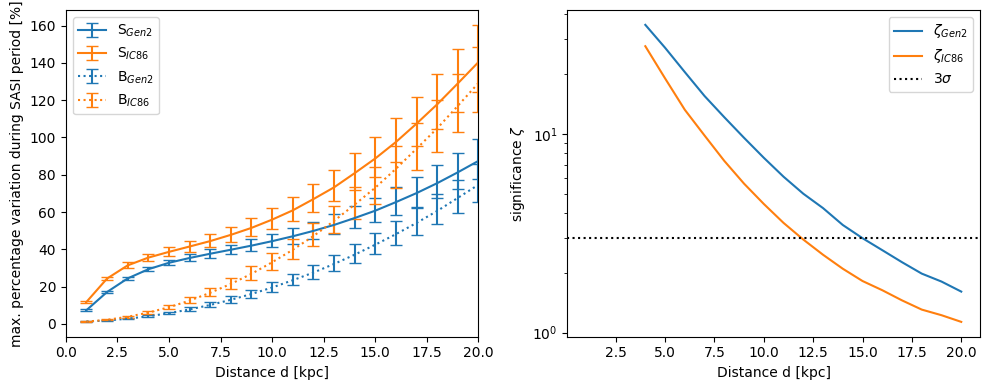

In [60]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].errorbar(x=distances, y=Sm_gen2.T[0],yerr=(Sm_gen2.T[0]-Sm_gen2.T[1],Sm_gen2.T[2]-Sm_gen2.T[0]), capsize=4, color = 'C0', label=r'S$_{Gen2}$')
ax[0].errorbar(x=distances, y=Sm_ic86.T[0],yerr=(Sm_ic86.T[0]-Sm_ic86.T[1],Sm_ic86.T[2]-Sm_ic86.T[0]), capsize=4, color = 'C1', label=r'S$_{IC86}$')
ax[0].errorbar(x=distances, y=Bm_gen2.T[0],yerr=(Bm_gen2.T[0]-Bm_gen2.T[1],Bm_gen2.T[2]-Bm_gen2.T[0]), capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].errorbar(x=distances, y=Bm_ic86.T[0],yerr=(Bm_ic86.T[0]-Bm_ic86.T[1],Bm_ic86.T[2]-Bm_ic86.T[0]), capsize=4, color = 'C1', ls = ':', label=r'B$_{IC86}$')
ax[0].set_xlabel('Distance d [kpc]')
ax[0].set_ylabel('max. percentage variation during SASI period [%]')
ax[0].set_xlim((0,20))
#ax[0].set_ylim((0,20))
ax[0].legend()

ax[1].plot(distances, Z_gen2, color = 'C0', label=r'$\zeta_{Gen2}$')
ax[1].plot(distances, Z_ic86, color = 'C1', label=r'$\zeta_{IC86}$')
ax[1].axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax[1].set_xlabel('Distance d [kpc]')
ax[1].set_ylabel('significance $\zeta$')
#ax[1].set_xlim((0,20))
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()
plt.tight_layout()

Here is where the testing begins!

The dip in significance (that would be visible if the transformation p-value -> Z score wasn't limited by precision) can be observed as well in the median of the signal and background TS plotted above. Normally, we would expect the TS statistic to flatten instead of decreasing at low distances. The signal our module sees at 0.1 kpc and 0.2 kpc would barely differ because the signal rate is so high that the dead time limits the maximal signal.

To show that I will plot the signal distribution at 1 kpc and 5 kpc for Gen2 and IceCube respectively. 

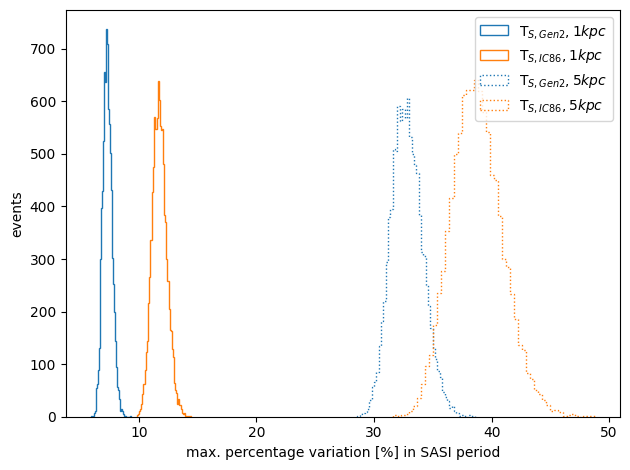

In [15]:
t, Sm_gen2_1kpc, Sm_ic86_1kpc, Bm_gen2_1kpc, Bm_ic86_1kpc = signal_processing(sim, dt=dt, distance=1*u.kpc, trials=10000, minmax_window=10, return_max_percentage=True)
t, Sm_gen2_5kpc, Sm_ic86_5kpc, Bm_gen2_5kpc, Bm_ic86_5kpc = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=10000, minmax_window=10, return_max_percentage=True)

plt.hist(Sm_gen2_1kpc*100, bins = 50, histtype='step', color = 'C0', ls = '-', label=r'T$_{S,Gen2}, 1 kpc$')
plt.hist(Sm_ic86_1kpc*100, bins = 50, histtype='step', color = 'C1', ls = '-', label=r'T$_{S,IC86}, 1 kpc$')

plt.hist(Sm_gen2_5kpc*100, bins = 50, histtype='step', color = 'C0', ls = ':', label=r'T$_{S,Gen2}, 5 kpc$')
plt.hist(Sm_ic86_5kpc*100, bins = 50, histtype='step', color = 'C1', ls = ':', label=r'T$_{S,IC86}, 5 kpc$')

plt.xlabel('max. percentage variation [%] in SASI period')
plt.ylabel('events')
#plt.xlim(0,100)
plt.legend()
plt.tight_layout()

As can be seen the distributions at 1 kpc and 5 kpc are seperated by about 20 %. It is not the fact that they are seperated but rather the scale of the seperation which is troubling. While we would expect the signal TS to have a distance dependence

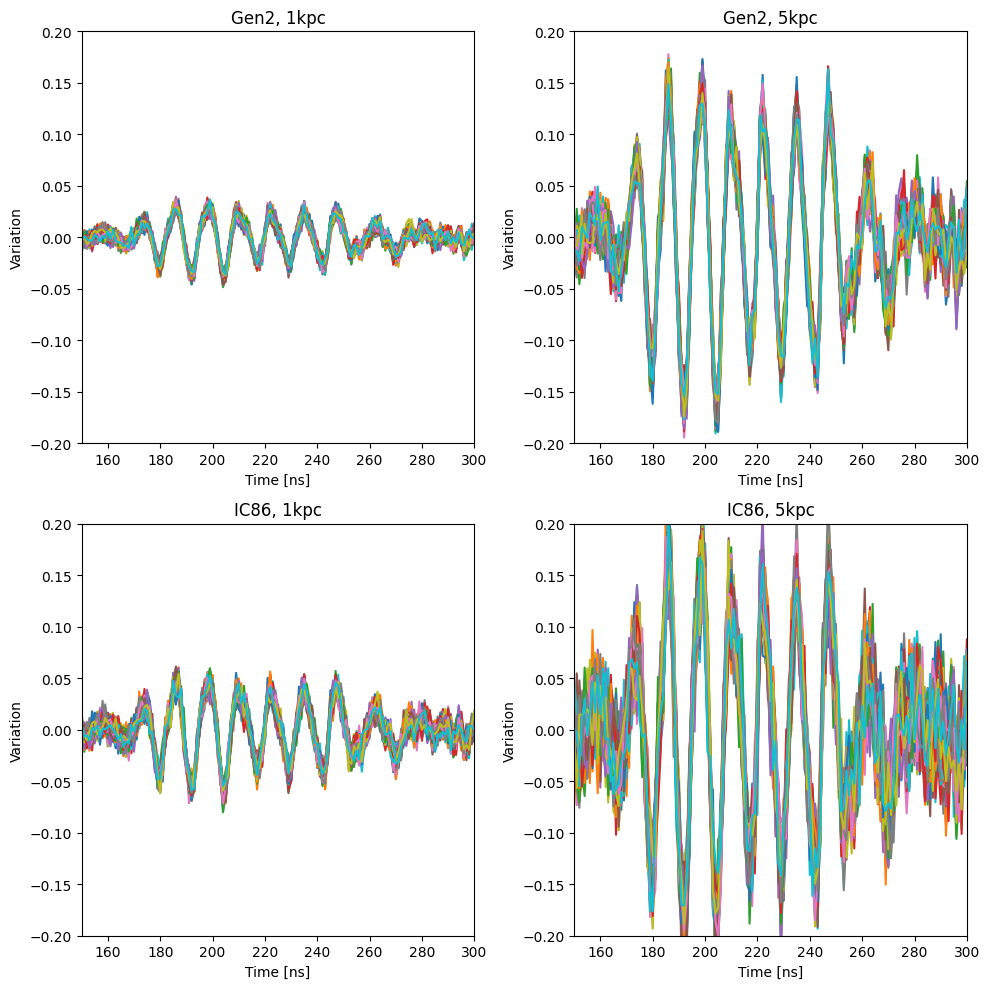

In [26]:
t, Sp_gen2_1kpc, Sp_ic86_1kpc, Bp_gen2_1kpc, Bp_ic86_1kpc = signal_processing(sim, dt=dt, distance=1*u.kpc, trials=100, minmax_window=10, return_percentage=True)
t, Sp_gen2_5kpc, Sp_ic86_5kpc, Bp_gen2_5kpc, Bp_ic86_5kpc = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=100, minmax_window=10, return_percentage=True)

fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, Sp_gen2_1kpc.T)
ax[1].plot(t, Sp_gen2_5kpc.T)
ax[2].plot(t, Sp_ic86_1kpc.T)
ax[3].plot(t, Sp_ic86_5kpc.T)

ax[0].set_title('Gen2, 1kpc')
ax[1].set_title('Gen2, 5kpc')
ax[2].set_title('IC86, 1kpc')
ax[3].set_title('IC86, 5kpc')

for i in range(4):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Variation')
    ax[i].set_xlim(150, 300)
    ax[i].set_ylim(-0.2,0.2)

The signal trials variation shows that at 5 kpc the variation is larger. However the signal variation is not clean, it contains background too. So let's check the raw data.

In [169]:
t, s_gen2_1kpc, sa_gen2_1kpc, b_gen2_1kpc, s_ic86_1kpc, sa_ic86_1kpc, b_ic86_1kpc = signal_processing(sim, dt=dt, distance=1*u.kpc, trials=100, minmax_window=10, return_raw=True)
t, s_gen2_5kpc, sa_gen2_5kpc, b_gen2_5kpc, s_ic86_5kpc, sa_ic86_5kpc, b_ic86_5kpc = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=100, minmax_window=10, return_raw=True)

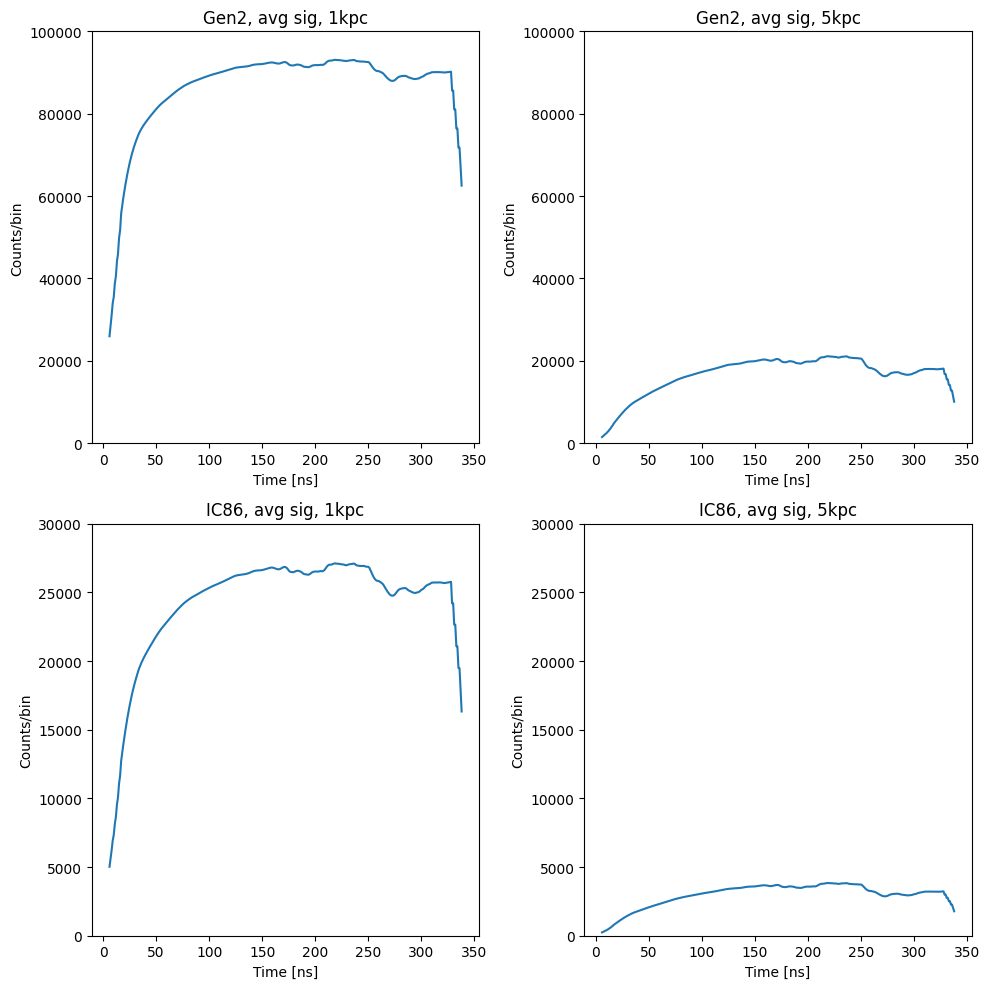

In [35]:
fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, sa_gen2_1kpc.T)
ax[1].plot(t, sa_gen2_5kpc.T)
ax[2].plot(t, sa_ic86_1kpc.T)
ax[3].plot(t, sa_ic86_5kpc.T)

ax[0].set_title('Gen2, avg sig, 1kpc')
ax[1].set_title('Gen2, avg sig, 5kpc')
ax[2].set_title('IC86, avg sig, 1kpc')
ax[3].set_title('IC86, avg sig, 5kpc')

for i in range(4):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    ax[i].set_ylim(0,100000) if i < 2 else ax[i].set_ylim(0,30000)

In [170]:
t_mask = np.logical_and(t>150*u.ms, t<300*u.ms)
print(s_gen2_1kpc.T[t_mask].max(),s_gen2_1kpc.T[t_mask].min(), np.median(s_gen2_1kpc.T[t_mask]))
print(s_gen2_5kpc.T[t_mask].max(),s_gen2_5kpc.T[t_mask].min(), np.median(s_gen2_5kpc.T[t_mask]))

96119.38671330242 85871.15053474964 91494.44103334754
24131.008457166285 15060.39320550043 19387.297318757806


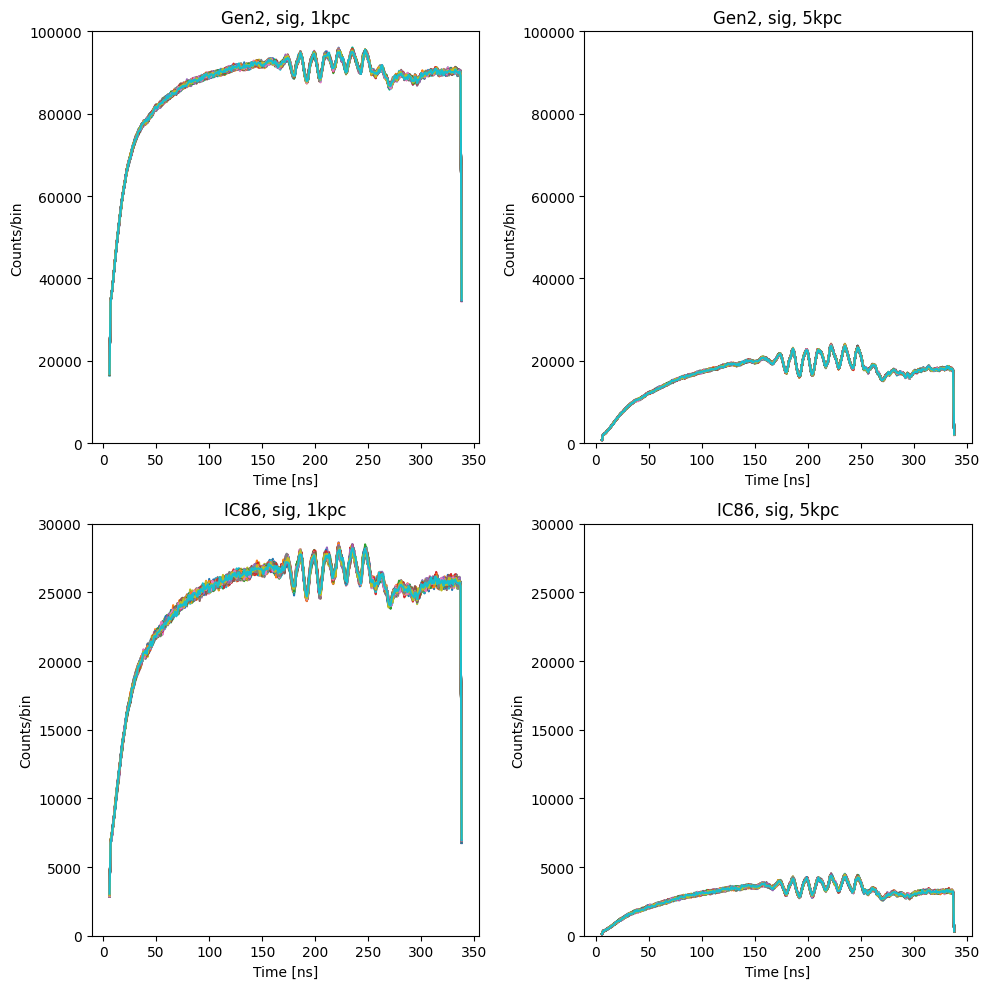

In [36]:
fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, s_gen2_1kpc.T)
ax[1].plot(t, s_gen2_5kpc.T)
ax[2].plot(t, s_ic86_1kpc.T)
ax[3].plot(t, s_ic86_5kpc.T)

ax[0].set_title('Gen2, sig, 1kpc')
ax[1].set_title('Gen2, sig, 5kpc')
ax[2].set_title('IC86, sig, 1kpc')
ax[3].set_title('IC86, sig, 5kpc')

for i in range(4):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    ax[i].set_ylim(0,100000) if i < 2 else ax[i].set_ylim(0,30000)

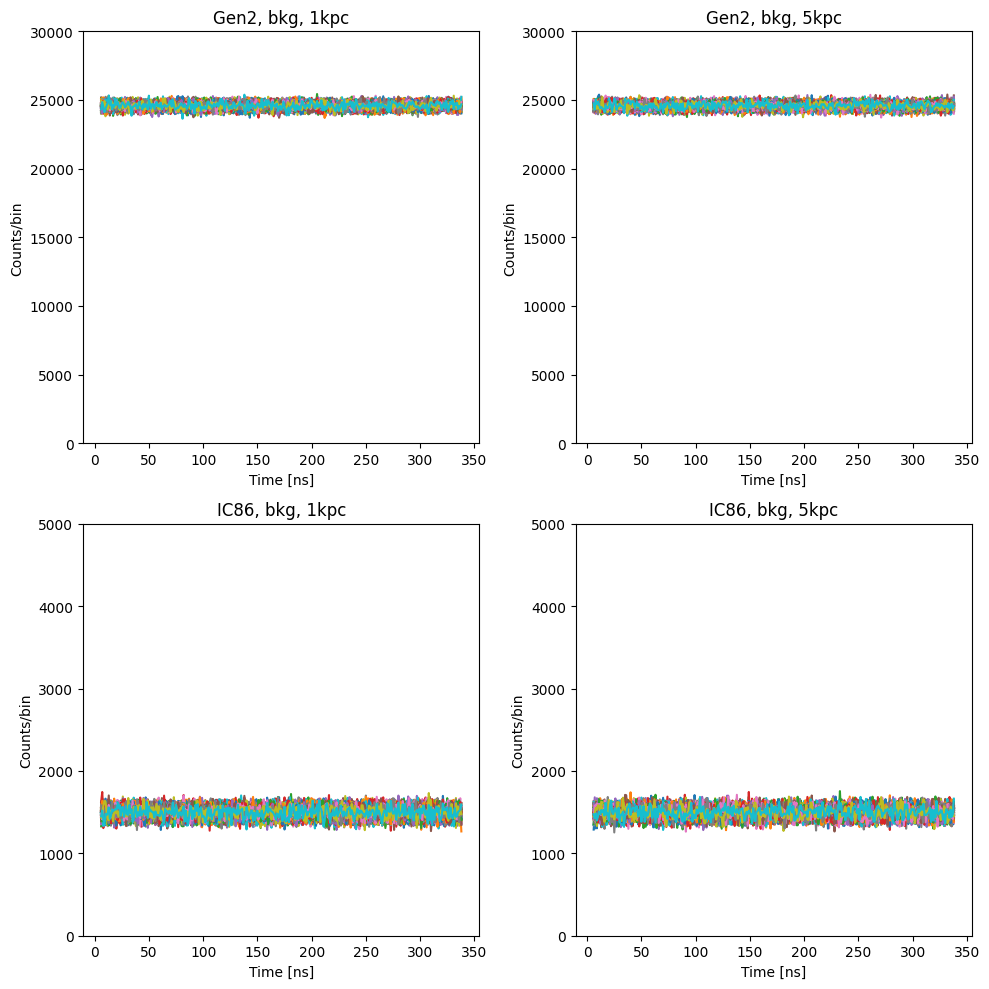

In [38]:
fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, b_gen2_1kpc.T)
ax[1].plot(t, b_gen2_5kpc.T)
ax[2].plot(t, b_ic86_1kpc.T)
ax[3].plot(t, b_ic86_5kpc.T)

ax[0].set_title('Gen2, bkg, 1kpc')
ax[1].set_title('Gen2, bkg, 5kpc')
ax[2].set_title('IC86, bkg, 1kpc')
ax[3].set_title('IC86, bkg, 5kpc')

for i in range(4):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    ax[i].set_ylim(0,30000) if i < 2 else ax[i].set_ylim(0,5000)

The above plots all look like what we would expect:
The background is distance independent, the signal as well as the averaged singal not. It should be shown that if the signal is dead time efficiency and distance corrected we would obtain a distance independent result. This will be the next step before we combine signal and background and build up the deviation and percentage deviation.

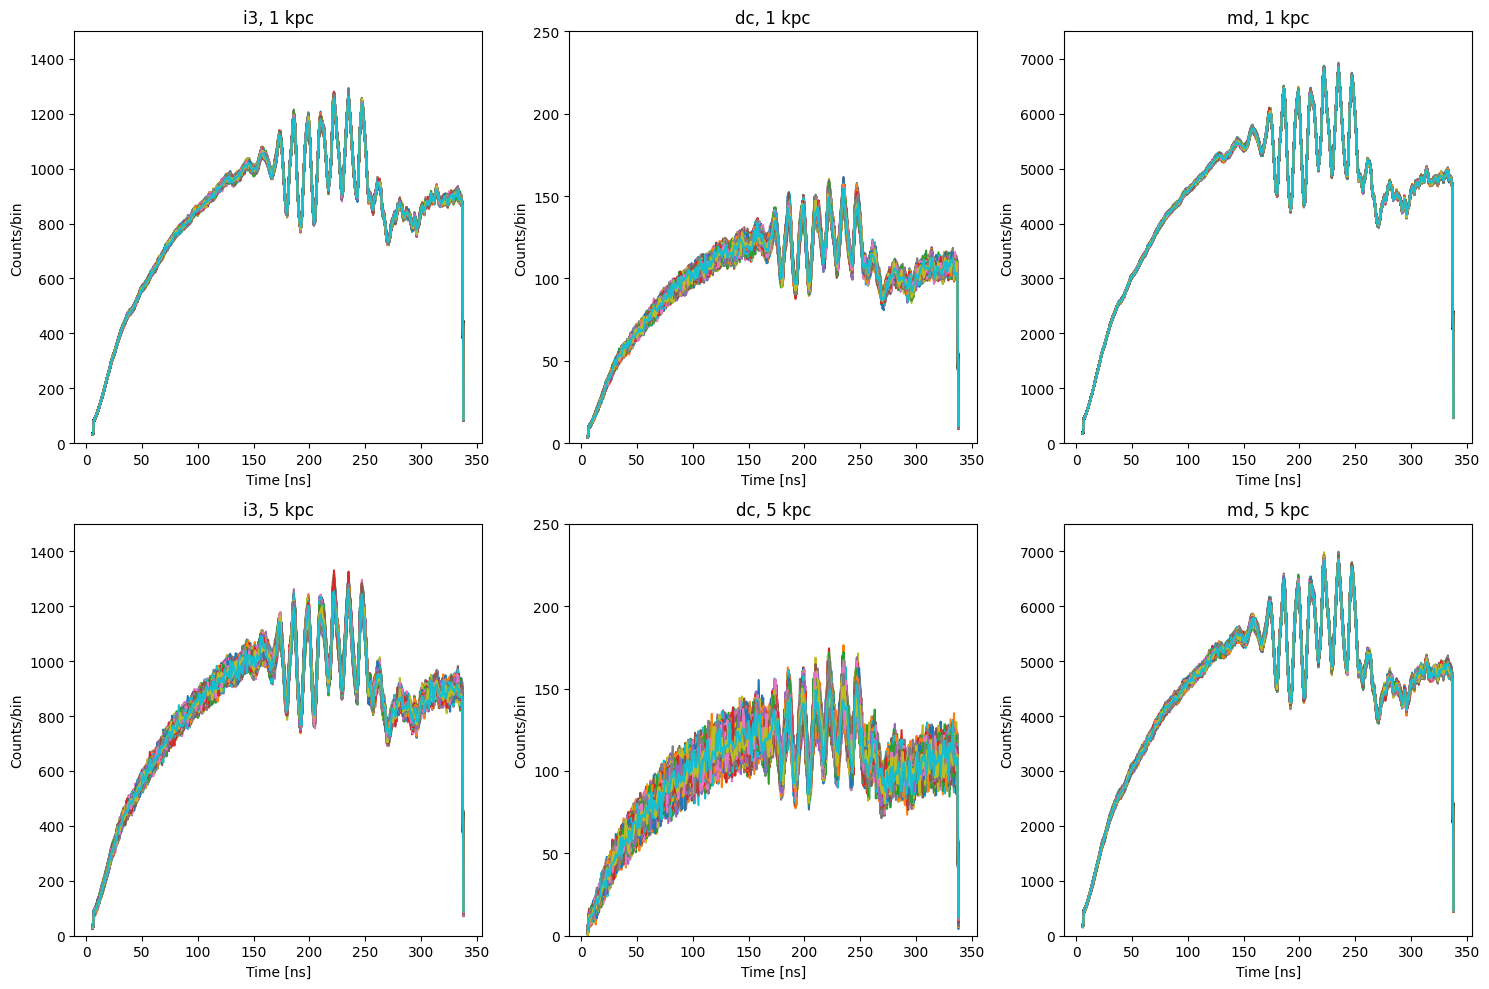

In [98]:
t, sc_i3_1kpc, sc_dc_1kpc, sc_md_1kpc = signal_processing(sim, dt=dt, distance=1*u.kpc, trials=100, minmax_window=10, return_corrected=True)
t, sc_i3_5kpc, sc_dc_5kpc, sc_md_5kpc = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=100, minmax_window=10, return_corrected=True)

fig, axs = plt.subplots(2, 3, figsize=(15,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, sc_i3_1kpc.T)
ax[3].plot(t, sc_i3_5kpc.T)

ax[1].plot(t, sc_dc_1kpc.T)
ax[4].plot(t, sc_dc_5kpc.T)

ax[2].plot(t, sc_md_1kpc.T)
ax[5].plot(t, sc_md_5kpc.T)


ax[0].set_title('i3, 1 kpc')
ax[1].set_title('dc, 1 kpc')
ax[2].set_title('md, 1 kpc')

ax[3].set_title('i3, 5 kpc')
ax[4].set_title('dc, 5 kpc')
ax[5].set_title('md, 5 kpc')

for i in range(6):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    if i%3 == 0:
        ax[i].set_ylim(0,1500)
    elif i%3 == 1:
        ax[i].set_ylim(0,250)
    elif i%3 == 2:
        ax[i].set_ylim(0,7500)


As we can see the corrected traces have no distance dependance as expected. We only observe a larger statistical variation in the 5 kpc case. Now lets assemble the signal and background numbers and see where the problem lies. Lets begin with the sum of signal and background (S_gen2 = s_gen2 + b_gen2, B_gen2 = sa_gen2 + b_gen2)

In [111]:
t, s_gen2_1kpc, sa_gen2_1kpc, b_gen2_1kpc, s_ic86_1kpc, sa_ic86_1kpc, b_ic86_1kpc = signal_processing(sim, dt=dt, distance=1*u.kpc, trials=100, minmax_window=10, return_raw=True)
t, s_gen2_5kpc, sa_gen2_5kpc, b_gen2_5kpc, s_ic86_5kpc, sa_ic86_5kpc, b_ic86_5kpc = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=100, minmax_window=10, return_raw=True)

In [114]:
# signal trials
S_gen2_1kpc = s_gen2_1kpc + b_gen2_1kpc
S_gen2_5kpc = s_gen2_5kpc + b_gen2_5kpc

S_ic86_1kpc = s_ic86_1kpc + b_ic86_1kpc
S_ic86_5kpc = s_ic86_5kpc + b_ic86_5kpc


# background trials
B_gen2_1kpc = sa_gen2_1kpc + b_gen2_1kpc
B_gen2_5kpc = sa_gen2_5kpc + b_gen2_5kpc

B_ic86_1kpc = sa_ic86_1kpc + b_ic86_1kpc
B_ic86_5kpc = sa_ic86_5kpc + b_ic86_5kpc

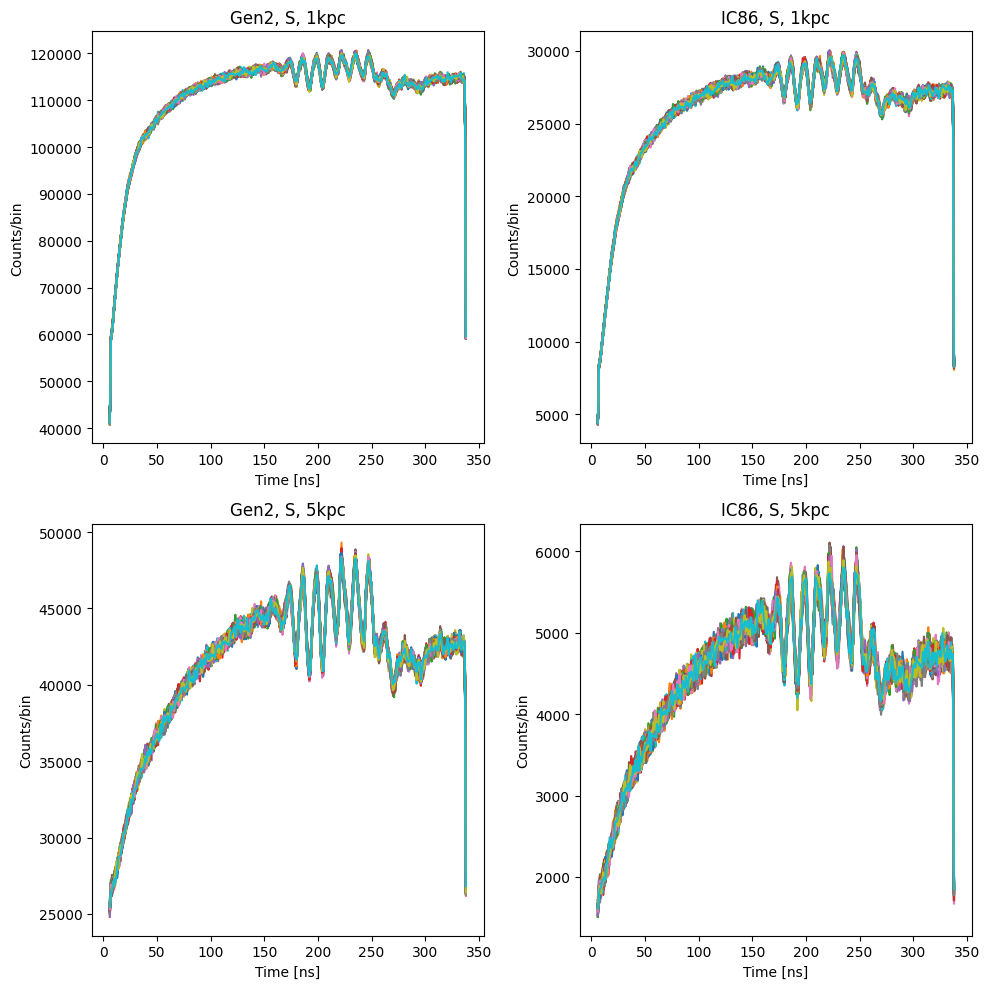

In [115]:
fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, S_gen2_1kpc.T)
ax[1].plot(t, S_ic86_1kpc.T)
ax[2].plot(t, S_gen2_5kpc.T)
ax[3].plot(t, S_ic86_5kpc.T)

ax[0].set_title('Gen2, S, 1kpc')
ax[1].set_title('IC86, S, 1kpc')
ax[2].set_title('Gen2, S, 5kpc')
ax[3].set_title('IC86, S, 5kpc')

for i in range(4):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    #ax[i].set_ylim(0,55000) if i < 2 else ax[i].set_ylim(0,20000)

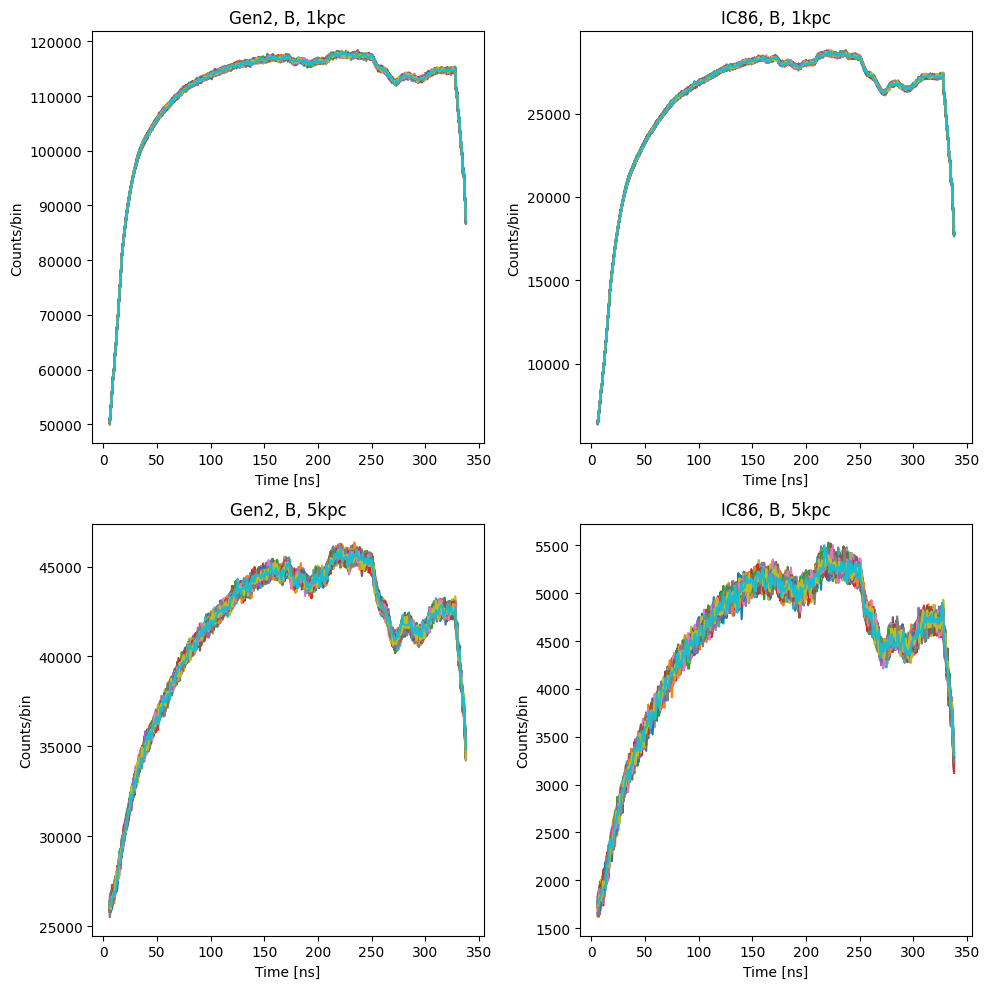

In [116]:
fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, B_gen2_1kpc.T)
ax[1].plot(t, B_ic86_1kpc.T)
ax[2].plot(t, B_gen2_5kpc.T)
ax[3].plot(t, B_ic86_5kpc.T)

ax[0].set_title('Gen2, B, 1kpc')
ax[1].set_title('IC86, B, 1kpc')
ax[2].set_title('Gen2, B, 5kpc')
ax[3].set_title('IC86, B, 5kpc')

for i in range(4):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    #ax[i].set_ylim(0,55000) if i < 2 else ax[i].set_ylim(0,20000)

Behaves as expected. Next up with average background subtraction. 
Sb_gen2 = s_gen2 + b_gen2 - ba_gen2, Bb_gen2 = sa_gen2 + b_gen2 - ba_gen2

In [171]:
t, s_gen2_1kpc, sa_gen2_1kpc, b_gen2_1kpc, s_ic86_1kpc, sa_ic86_1kpc, b_ic86_1kpc = signal_processing(sim, dt=dt, distance=1*u.kpc, trials=100, minmax_window=10, return_raw=True)
t, s_gen2_5kpc, sa_gen2_5kpc, b_gen2_5kpc, s_ic86_5kpc, sa_ic86_5kpc, b_ic86_5kpc = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=100, minmax_window=10, return_raw=True)
t, s_gen2_10kpc, sa_gen2_10kpc, b_gen2_10kpc, s_ic86_10kpc, sa_ic86_10kpc, b_ic86_10kpc = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=100, minmax_window=10, return_raw=True)

In [172]:
# signal trials
Sb_gen2_1kpc = s_gen2_1kpc + b_gen2_1kpc - ba_gen2
Sb_gen2_5kpc = s_gen2_5kpc + b_gen2_5kpc - ba_gen2
Sb_gen2_10kpc = s_gen2_10kpc + b_gen2_10kpc - ba_gen2

Sb_ic86_1kpc = s_ic86_1kpc + b_ic86_1kpc - ba_ic86
Sb_ic86_5kpc = s_ic86_5kpc + b_ic86_5kpc - ba_ic86
Sb_ic86_10kpc = s_ic86_10kpc + b_ic86_10kpc - ba_ic86


# background trials
Bb_gen2_1kpc = sa_gen2_1kpc + b_gen2_1kpc - ba_gen2
Bb_gen2_5kpc = sa_gen2_5kpc + b_gen2_5kpc - ba_gen2
Bb_gen2_10kpc = sa_gen2_10kpc + b_gen2_10kpc - ba_gen2

Bb_ic86_1kpc = sa_ic86_1kpc + b_ic86_1kpc - ba_ic86
Bb_ic86_5kpc = sa_ic86_5kpc + b_ic86_5kpc - ba_ic86
Bb_ic86_10kpc = sa_ic86_10kpc + b_ic86_10kpc - ba_ic86

In [17]:
t_mask = np.logical_and(t>150*u.ms, t<300*u.ms)
print(Sb_gen2_1kpc.T[t_mask].max(),Sb_gen2_1kpc.T[t_mask].min(), np.median(Sb_gen2_1kpc.T[t_mask]))
print(Sb_gen2_5kpc.T[t_mask].max(),Sb_gen2_5kpc.T[t_mask].min(), np.median(Sb_gen2_5kpc.T[t_mask]))
print(Sb_gen2_10kpc.T[t_mask].max(),Sb_gen2_10kpc.T[t_mask].min(), np.median(Sb_gen2_10kpc.T[t_mask]))

NameError: name 'Sb_gen2_1kpc' is not defined

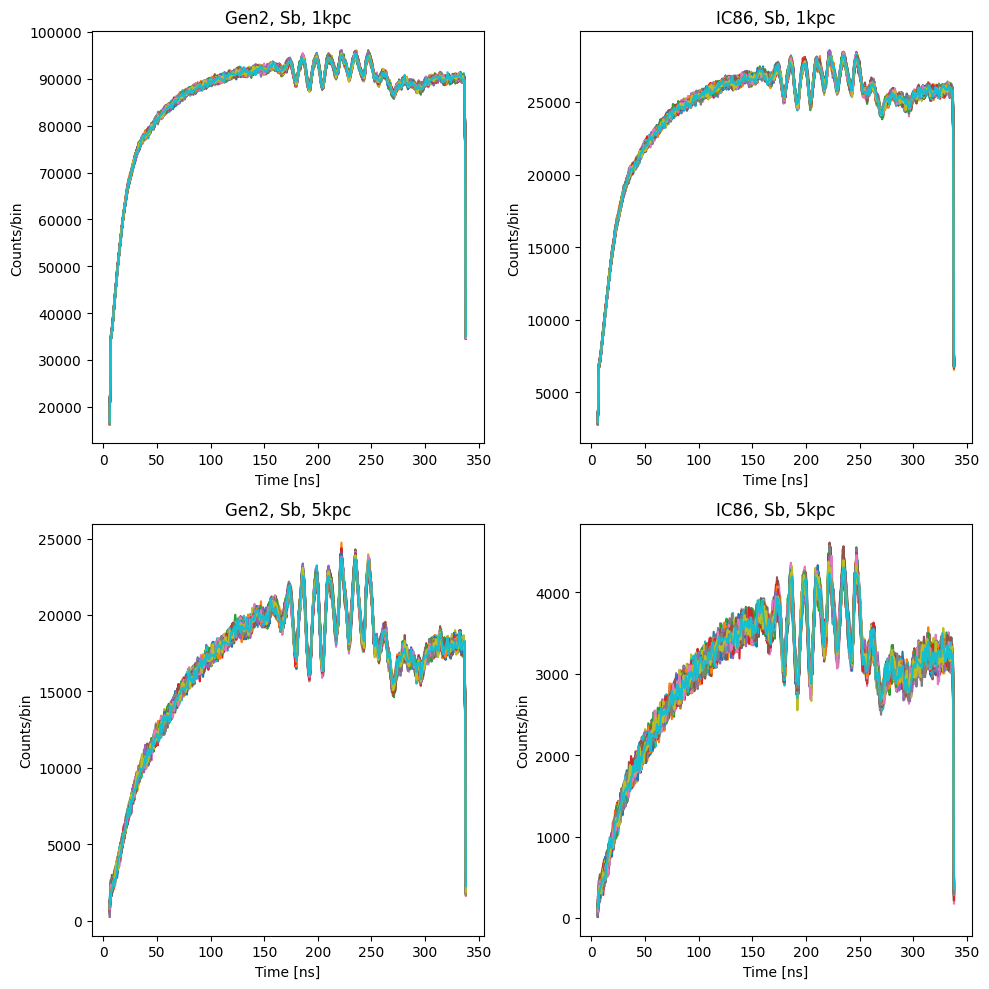

In [128]:
fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, Sb_gen2_1kpc.T)
ax[1].plot(t, Sb_ic86_1kpc.T)
ax[2].plot(t, Sb_gen2_5kpc.T)
ax[3].plot(t, Sb_ic86_5kpc.T)

ax[0].set_title('Gen2, Sb, 1kpc')
ax[1].set_title('IC86, Sb, 1kpc')
ax[2].set_title('Gen2, Sb, 5kpc')
ax[3].set_title('IC86, Sb, 5kpc')

for i in range(4):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    #ax[i].set_ylim(0,55000) if i < 2 else ax[i].set_ylim(0,20000)

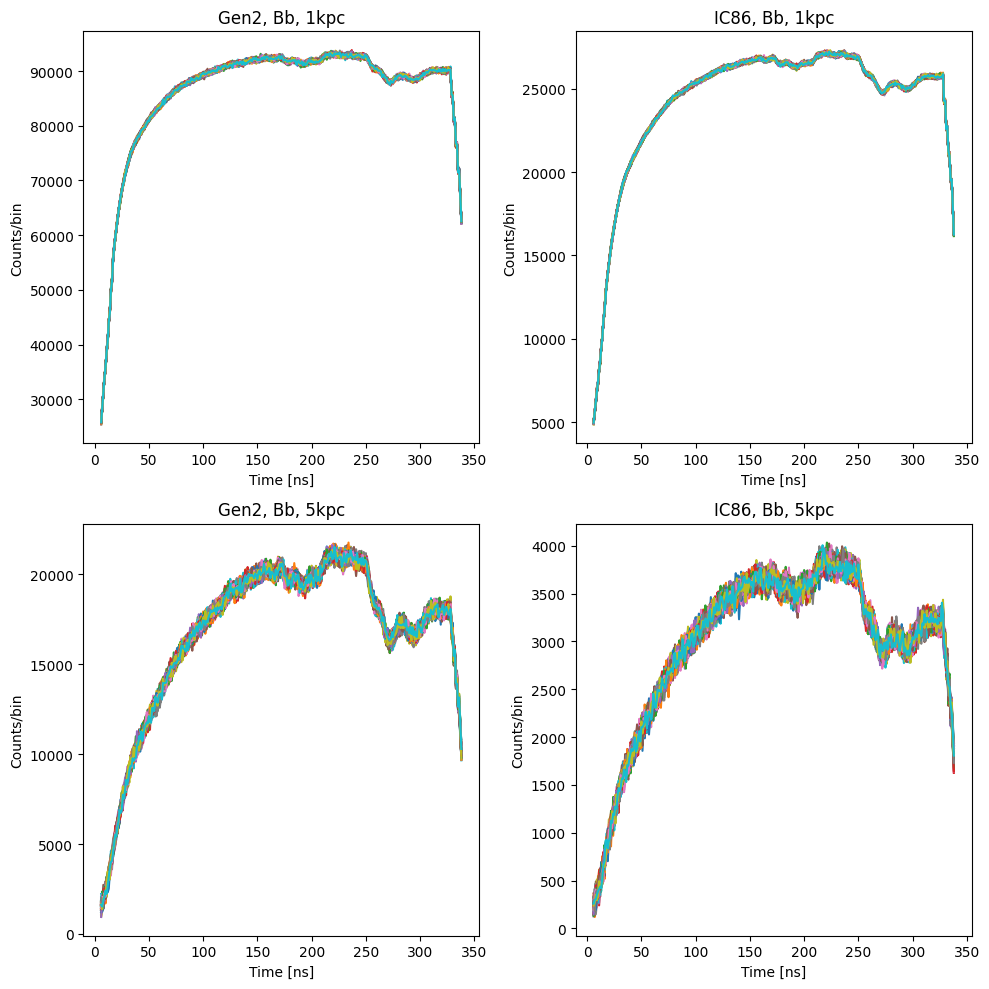

In [129]:
fig, axs = plt.subplots(2,2, figsize = (10,10), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, Bb_gen2_1kpc.T)
ax[1].plot(t, Bb_ic86_1kpc.T)
ax[2].plot(t, Bb_gen2_5kpc.T)
ax[3].plot(t, Bb_ic86_5kpc.T)

ax[0].set_title('Gen2, Bb, 1kpc')
ax[1].set_title('IC86, Bb, 1kpc')
ax[2].set_title('Gen2, Bb, 5kpc')
ax[3].set_title('IC86, Bb, 5kpc')

for i in range(4):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    #ax[i].set_ylim(0,55000) if i < 2 else ax[i].set_ylim(0,20000)

Perfect! Let's move to the percentage deviation!

In [157]:
t, s_gen2_1kpc, sa_gen2_1kpc, b_gen2_1kpc, s_ic86_1kpc, sa_ic86_1kpc, b_ic86_1kpc = signal_processing(sim, dt=dt, distance=1*u.kpc, trials=100, minmax_window=10, return_raw=True)
t, s_gen2_5kpc, sa_gen2_5kpc, b_gen2_5kpc, s_ic86_5kpc, sa_ic86_5kpc, b_ic86_5kpc = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=100, minmax_window=10, return_raw=True)
t, s_gen2_10kpc, sa_gen2_10kpc, b_gen2_10kpc, s_ic86_10kpc, sa_ic86_10kpc, b_ic86_10kpc = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=100, minmax_window=10, return_raw=True)

In [158]:
# signal trials
Sp_gen2_1kpc = (s_gen2_1kpc + b_gen2_1kpc - ba_gen2)/sa_gen2_1kpc - 1
Sp_gen2_5kpc = (s_gen2_5kpc + b_gen2_5kpc - ba_gen2)/sa_gen2_5kpc - 1
Sp_gen2_10kpc = (s_gen2_10kpc + b_gen2_10kpc - ba_gen2)/sa_gen2_10kpc - 1

Sp_ic86_1kpc = (s_ic86_1kpc + b_ic86_1kpc - ba_ic86)/sa_ic86_1kpc - 1
Sp_ic86_5kpc = (s_ic86_5kpc + b_ic86_5kpc - ba_ic86)/sa_ic86_5kpc - 1
Sp_ic86_10kpc = (s_ic86_10kpc + b_ic86_10kpc - ba_ic86)/sa_ic86_10kpc - 1

# background trials
Bp_gen2_1kpc = (sa_gen2_1kpc + b_gen2_1kpc - ba_gen2)/sa_gen2_1kpc - 1
Bp_gen2_5kpc = (sa_gen2_5kpc + b_gen2_5kpc - ba_gen2)/sa_gen2_5kpc - 1
Bp_gen2_10kpc = (sa_gen2_10kpc + b_gen2_10kpc - ba_gen2)/sa_gen2_10kpc - 1


Bp_ic86_1kpc = (sa_ic86_1kpc + b_ic86_1kpc - ba_ic86)/sa_ic86_1kpc - 1
Bp_ic86_5kpc = (sa_ic86_5kpc + b_ic86_5kpc - ba_ic86)/sa_ic86_5kpc - 1
Bp_ic86_10kpc = (sa_ic86_10kpc + b_ic86_10kpc - ba_ic86)/sa_ic86_10kpc - 1

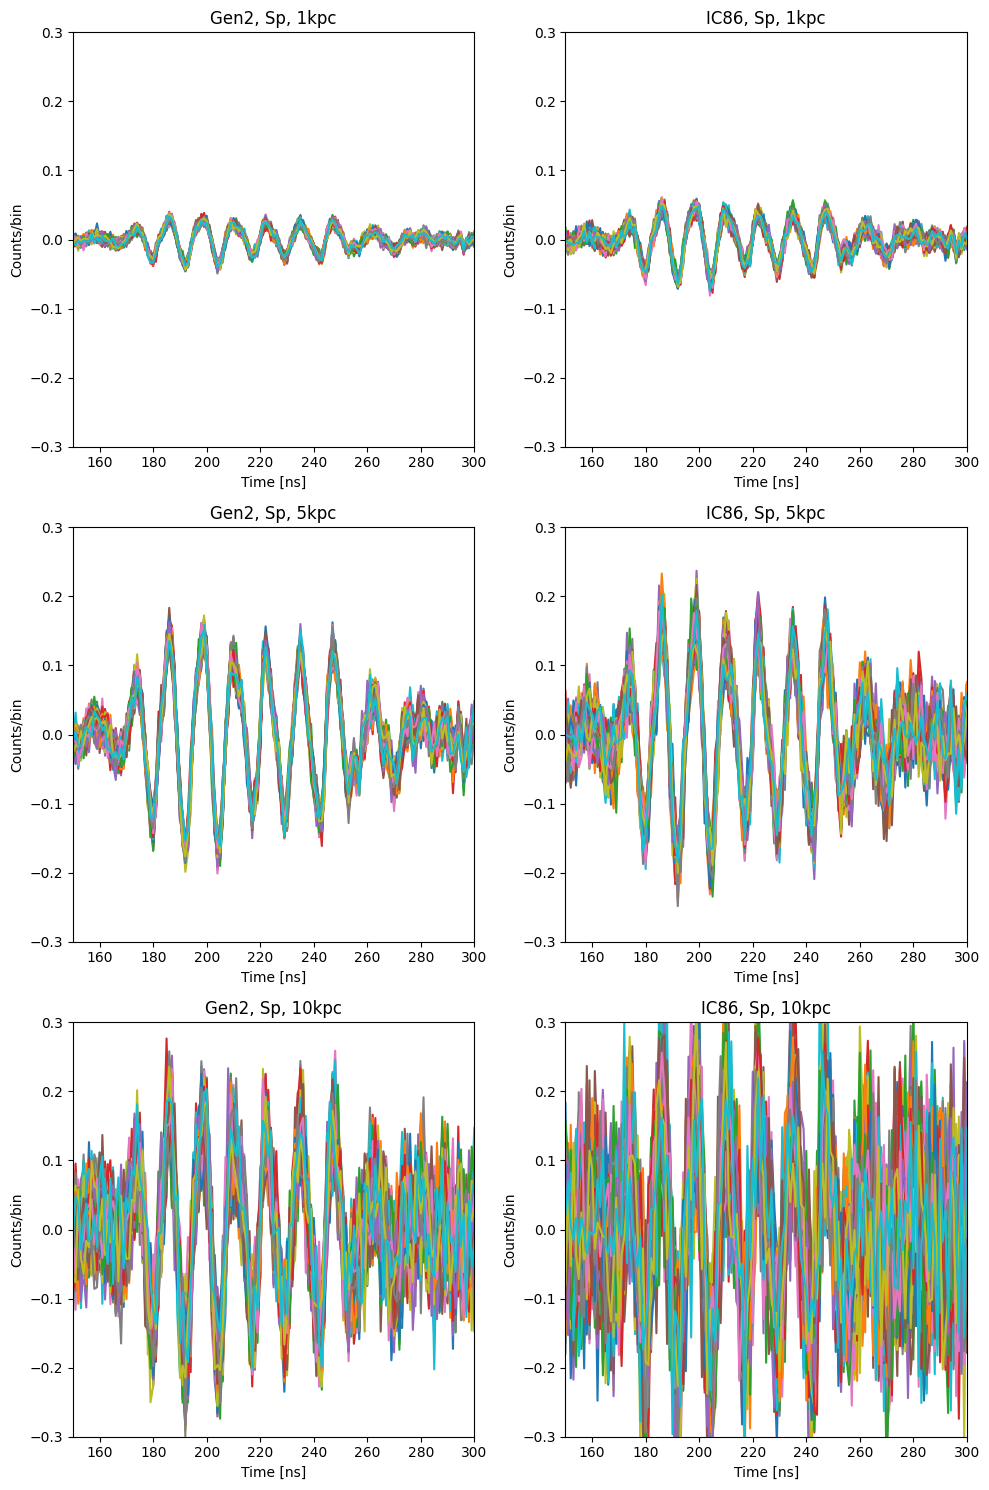

In [162]:
fig, axs = plt.subplots(3,2, figsize = (10,15), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, Sp_gen2_1kpc.T)
ax[1].plot(t, Sp_ic86_1kpc.T)
ax[2].plot(t, Sp_gen2_5kpc.T)
ax[3].plot(t, Sp_ic86_5kpc.T)
ax[4].plot(t, Sp_gen2_10kpc.T)
ax[5].plot(t, Sp_ic86_10kpc.T)

ax[0].set_title('Gen2, Sp, 1kpc')
ax[1].set_title('IC86, Sp, 1kpc')
ax[2].set_title('Gen2, Sp, 5kpc')
ax[3].set_title('IC86, Sp, 5kpc')
ax[4].set_title('Gen2, Sp, 10kpc')
ax[5].set_title('IC86, Sp, 10kpc')

for i in range(6):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    ax[i].set_xlim(150,300)
    ax[i].set_ylim(-0.3,0.3)

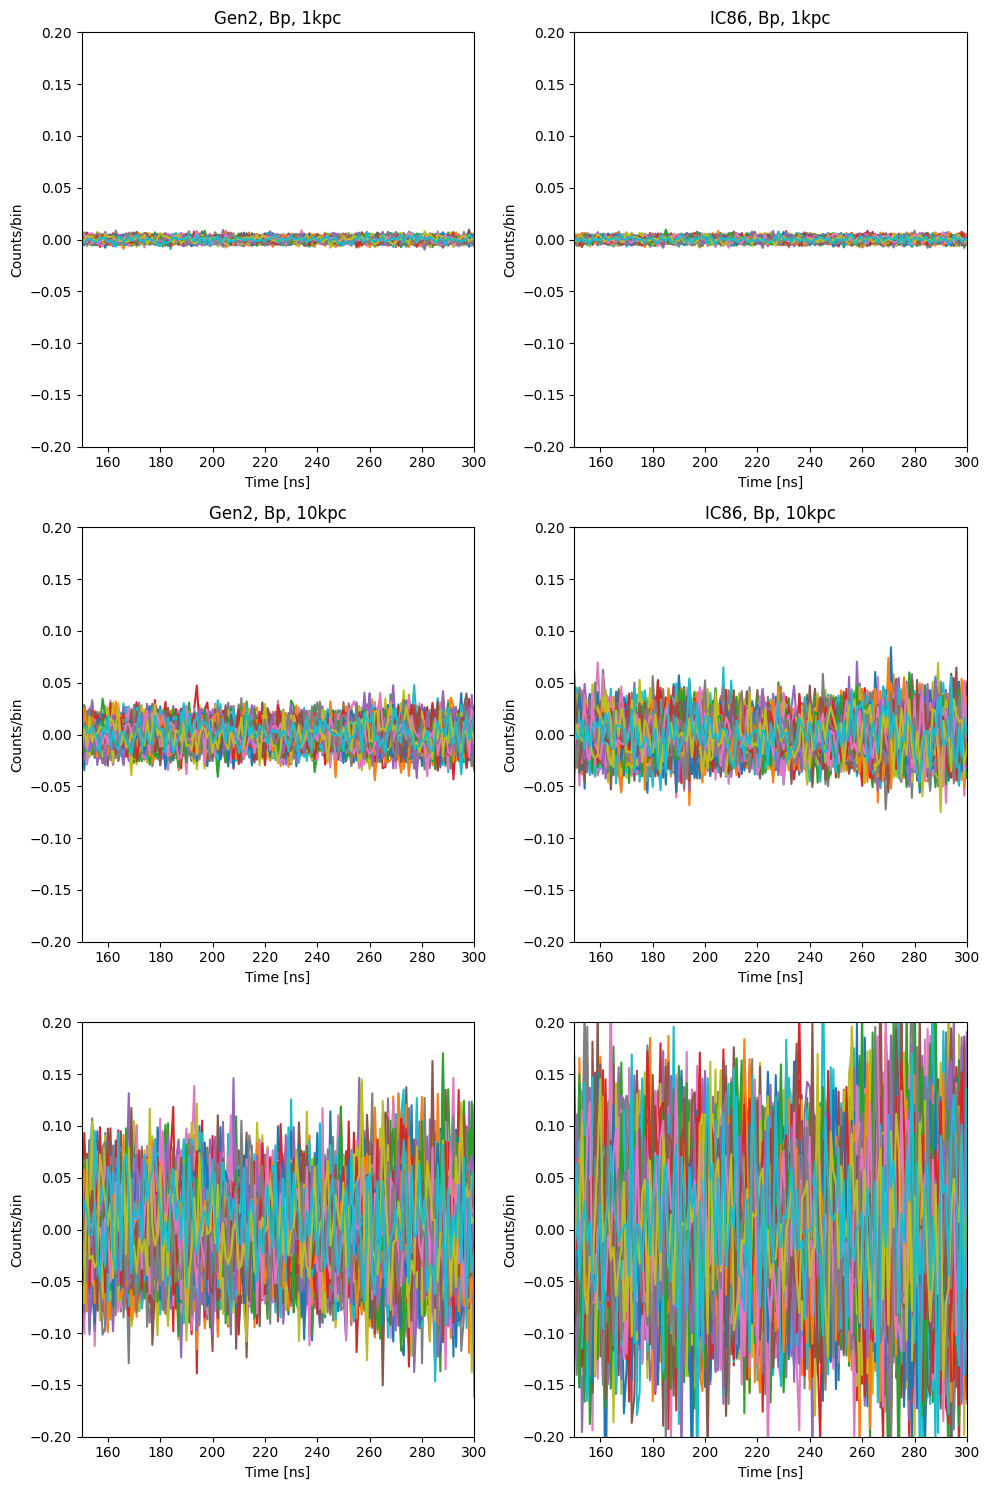

In [165]:
fig, axs = plt.subplots(3,2, figsize = (10,15), tight_layout = True)
ax = axs.ravel()

ax[0].plot(t, Bp_gen2_1kpc.T)
ax[1].plot(t, Bp_ic86_1kpc.T)
ax[2].plot(t, Bp_gen2_5kpc.T)
ax[3].plot(t, Bp_ic86_5kpc.T)
ax[4].plot(t, Bp_gen2_10kpc.T)
ax[5].plot(t, Bp_ic86_10kpc.T)

ax[0].set_title('Gen2, Bp, 1kpc')
ax[1].set_title('IC86, Bp, 1kpc')
ax[2].set_title('Gen2, Bp, 5kpc')
ax[3].set_title('IC86, Bp, 5kpc')
ax[2].set_title('Gen2, Bp, 10kpc')
ax[3].set_title('IC86, Bp, 10kpc')

for i in range(6):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel('Counts/bin')
    ax[i].set_xlim(150,300)
    ax[i].set_ylim(-0.2,0.2)

In [52]:
t, s_gen2_05kpc, sa_gen2_05kpc, b_gen2_05kpc, s_ic86_05kpc, sa_ic86_05kpc, b_ic86_05kpc = signal_processing(sim, dt=dt, distance=0.5*u.kpc, trials=100, minmax_window=10, return_raw=True)
t, s_gen2_5kpc, sa_gen2_5kpc, b_gen2_5kpc, s_ic86_5kpc, sa_ic86_5kpc, b_ic86_5kpc = signal_processing(sim, dt=dt, distance=5*u.kpc, trials=100, minmax_window=10, return_raw=True)
t, s_gen2_20kpc, sa_gen2_20kpc, b_gen2_20kpc, s_ic86_20kpc, sa_ic86_20kpc, b_ic86_20kpc = signal_processing(sim, dt=dt, distance=20*u.kpc, trials=100, minmax_window=10, return_raw=True)

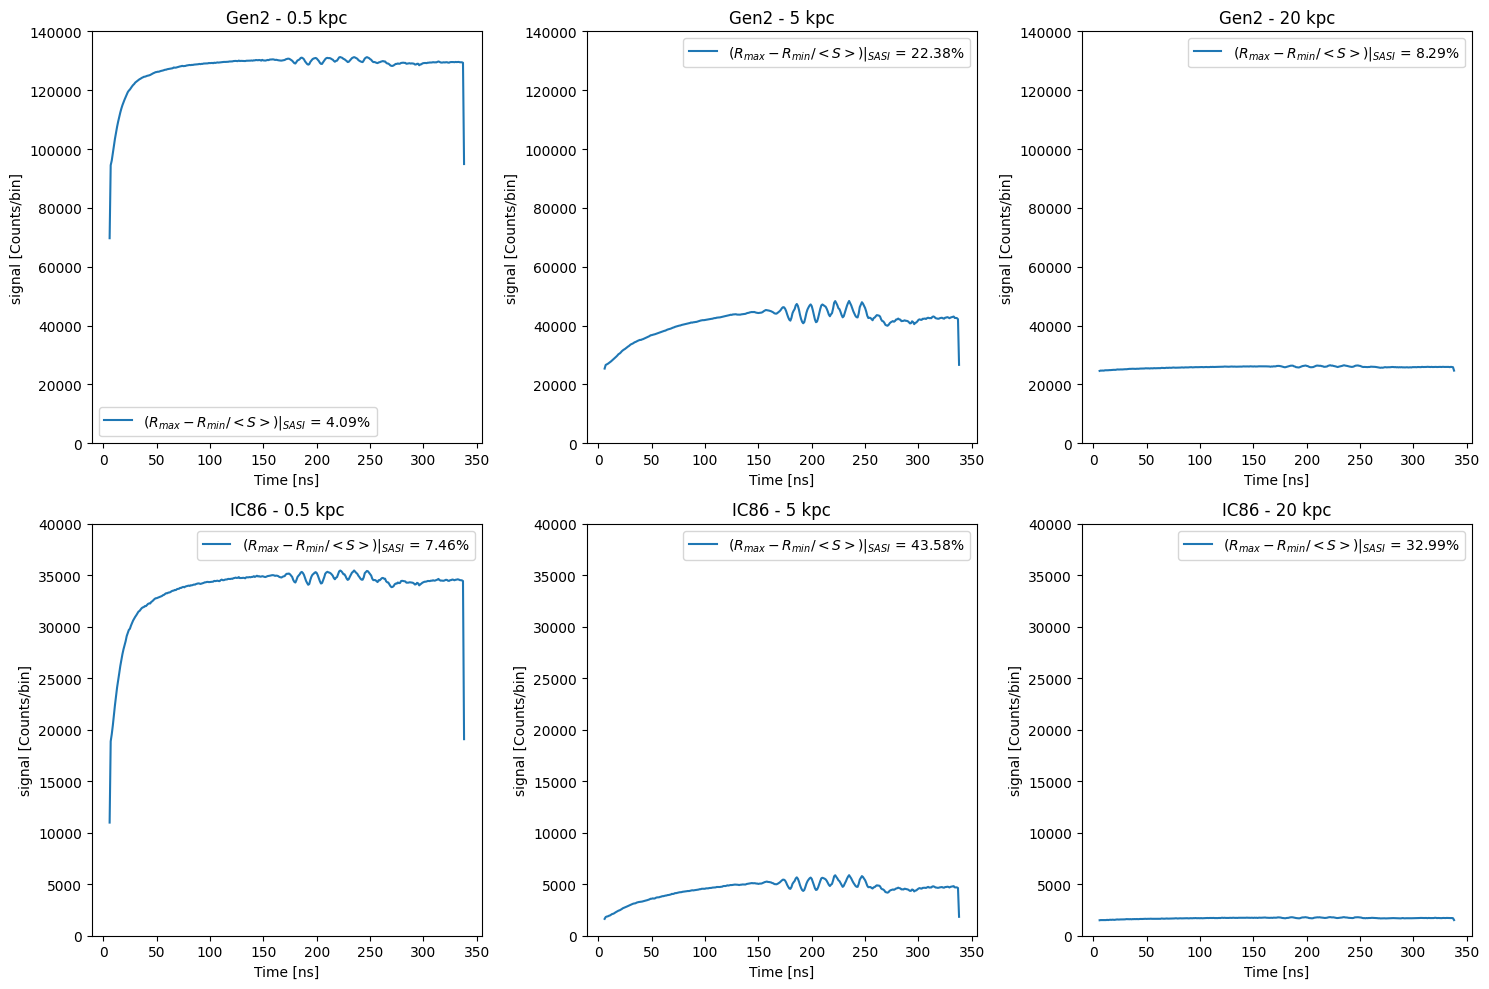

In [54]:
t_mask = np.logical_and(t>150*u.ms, t<300*u.ms)

r_gen2_05kpc = s_gen2_05kpc + b_gen2_05kpc
r_gen2_5kpc = s_gen2_5kpc + b_gen2_5kpc
r_gen2_20kpc = s_gen2_20kpc + b_gen2_20kpc
r_ic86_05kpc = s_ic86_05kpc + b_ic86_05kpc
r_ic86_5kpc = s_ic86_5kpc + b_ic86_5kpc
r_ic86_20kpc = s_ic86_20kpc + b_ic86_20kpc

fig, axs = plt.subplots(2,3, figsize = (15,10), tight_layout = True)
ax = axs.ravel()

v_gen2_05kpc = (r_gen2_05kpc.T[t_mask].max() - r_gen2_05kpc.T[t_mask].min())/np.median(r_gen2_05kpc.T[t_mask])
v_gen2_5kpc = (r_gen2_5kpc.T[t_mask].max() - r_gen2_5kpc.T[t_mask].min())/np.median(r_gen2_5kpc.T[t_mask])
v_gen2_20kpc = (r_gen2_20kpc.T[t_mask].max() - r_gen2_20kpc.T[t_mask].min())/np.median(r_gen2_20kpc.T[t_mask])
v_ic86_05kpc = (r_ic86_05kpc.T[t_mask].max() - r_ic86_05kpc.T[t_mask].min())/np.median(r_ic86_05kpc.T[t_mask])
v_ic86_5kpc = (r_ic86_5kpc.T[t_mask].max() - r_ic86_5kpc.T[t_mask].min())/np.median(r_ic86_5kpc.T[t_mask])
v_ic86_20kpc = (r_ic86_20kpc.T[t_mask].max() - r_ic86_20kpc.T[t_mask].min())/np.median(r_ic86_20kpc.T[t_mask])

ax[0].plot(t, np.median(r_gen2_05kpc.T, axis = -1), label = r'$(R_{{max}} - R_{{min}}/<S>) |_{{SASI}}$ = {:.2f}%'.format(v_gen2_05kpc*100))
ax[1].plot(t, np.median(r_gen2_5kpc.T, axis = -1), label = r'$(R_{{max}} - R_{{min}}/<S>) |_{{SASI}}$ = {:.2f}%'.format(v_gen2_5kpc*100))
ax[2].plot(t, np.median(r_gen2_20kpc.T, axis = -1), label = r'$(R_{{max}} - R_{{min}}/<S>) |_{{SASI}}$ = {:.2f}%'.format(v_gen2_20kpc*100))
ax[3].plot(t, np.median(r_ic86_05kpc.T, axis = -1), label = r'$(R_{{max}} - R_{{min}}/<S>) |_{{SASI}}$ = {:.2f}%'.format(v_ic86_05kpc*100))
ax[4].plot(t, np.median(r_ic86_5kpc.T, axis = -1), label = r'$(R_{{max}} - R_{{min}}/<S>) |_{{SASI}}$ = {:.2f}%'.format(v_ic86_5kpc*100))
ax[5].plot(t, np.median(r_ic86_20kpc.T, axis = -1), label = r'$(R_{{max}} - R_{{min}}/<S>) |_{{SASI}}$ = {:.2f}%'.format(v_ic86_20kpc*100))

ax[0].set_title('Gen2 - 0.5 kpc')
ax[1].set_title('Gen2 - 5 kpc')
ax[2].set_title('Gen2 - 20 kpc')
ax[3].set_title('IC86 - 0.5 kpc')
ax[4].set_title('IC86 - 5 kpc')
ax[5].set_title('IC86 - 20 kpc')

for i in range(6):
    ax[i].set_xlabel('Time [ns]')
    ax[i].set_ylabel(r'signal [Counts/bin]')
    ax[i].set_ylim(0,140000) if i < 3 else ax[i].set_ylim(0,40000)
    ax[i].legend()

In [113]:
sim.scale_result(distance=0.00000001*u.kpc)
np.max(sim.detector_hits(subdetector='md'))* 1/sim.detector.n_md * 1/dt.to_value(u.s)

3884.985816142987

In [72]:
0.957*4000

3828.0

In [65]:
def fu(f):
    return 0.884/(1+250E-6*f)

In [115]:
sim.detector.md_bg(dt=dt) * 1/dt.to_value(u.s) * 1/sim.detector.n_md

array([2356.80133229])